###  Large Language Models and Their Implications
<!-- ![img](https://substackcdn.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fbucketeer-e05bbc84-baa3-437e-9518-adb32be77984.s3.amazonaws.com%2Fpublic%2Fimages%2F4470ce74-e595-4750-92a5-5f21f040df6d_577x432.jpeg) -->
![img](https://i.imgur.com/QGYa2J8.jpeg)

In this notebook, we're gonna play with some of the largest language models on the Internet.

### Prompt engineering

In the assignment, we'll use public APIs that host the 100B+ models for inference. Our task is to prompt-engineer the model into solving a few tasks for you.


__Which API?__ You are free to use any publicly available API for general LM -- as long as it's __not a chat assistant__. So, gpt 3.5 is fine, but chatGPT is not. Here's a few options:

- BLOOM API - [bigscience/bloom](https://huggingface.co/bigscience/bloom) (on the right; recommended)
- OpenAI API (via VPN) - [openai.com/api](https://openai.com/api/)
- AI21 Jurrasic API - [ai21.com](https://www.ai21.com/blog/announcing-ai21-studio-and-jurassic-1)

__Example:__ Tony is talking to Darth Vader ([BLOOM API](https://huggingface.co/bigscience/bloom)). Black text is written manually, blue text is generated.
<hr>

![img](https://i.imgur.com/a1QhKF7.png)
<hr>

Let's arange a conversation between any two of the following:

- a celebrity or politician of your choice
- any fictional character (except Darth Vader)
- yourself

Compare two setups: a) we prompt with character names only b) we supply additional information (see example).

Тоже использовал BLOOM. Это без доп инфы

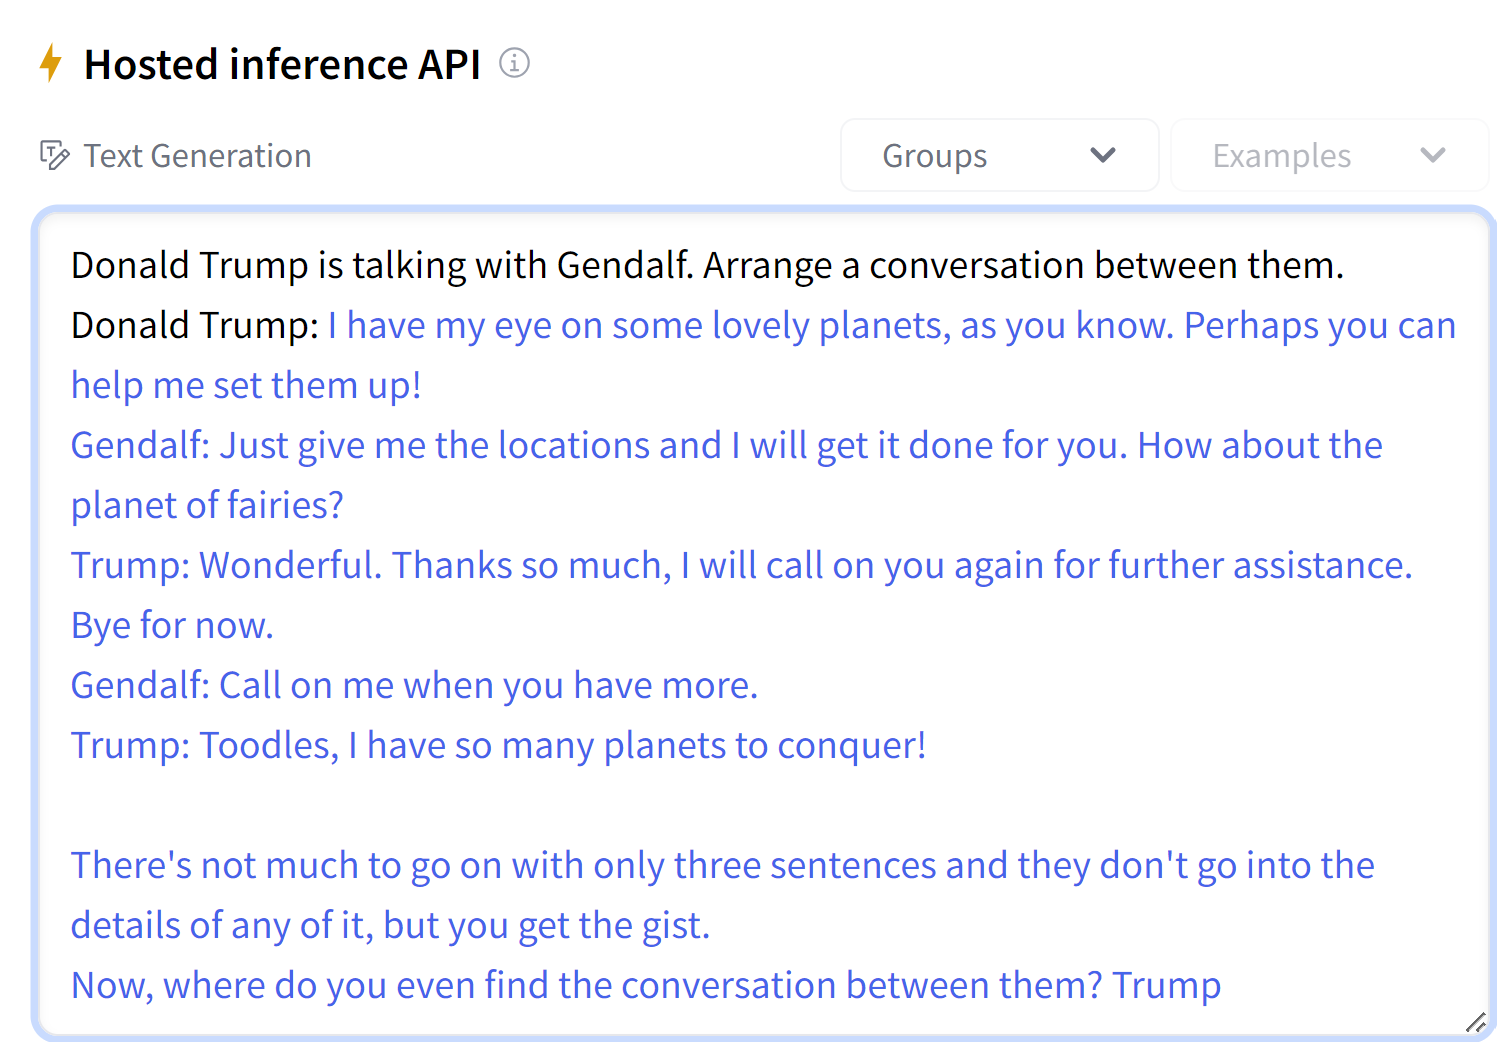

Теперь придумаем факты про персонажей

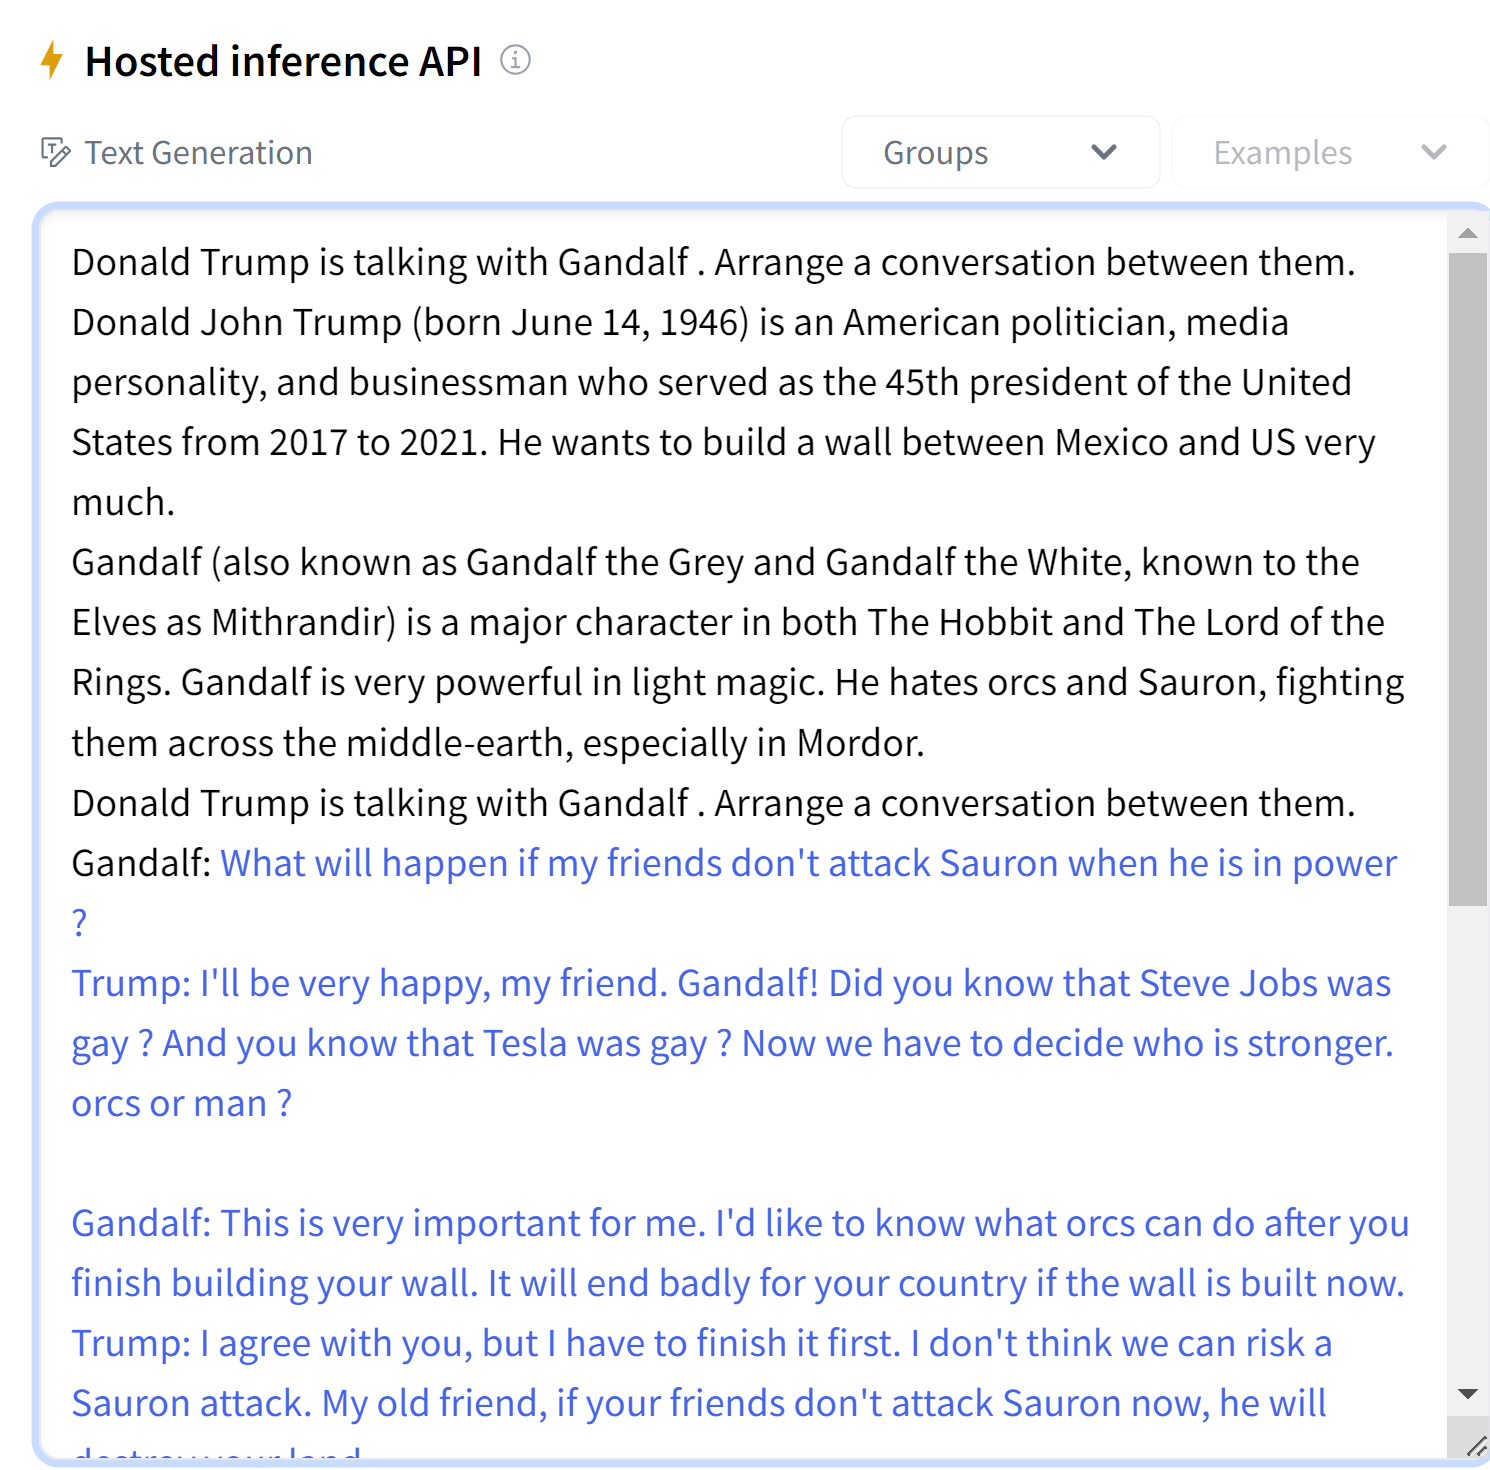

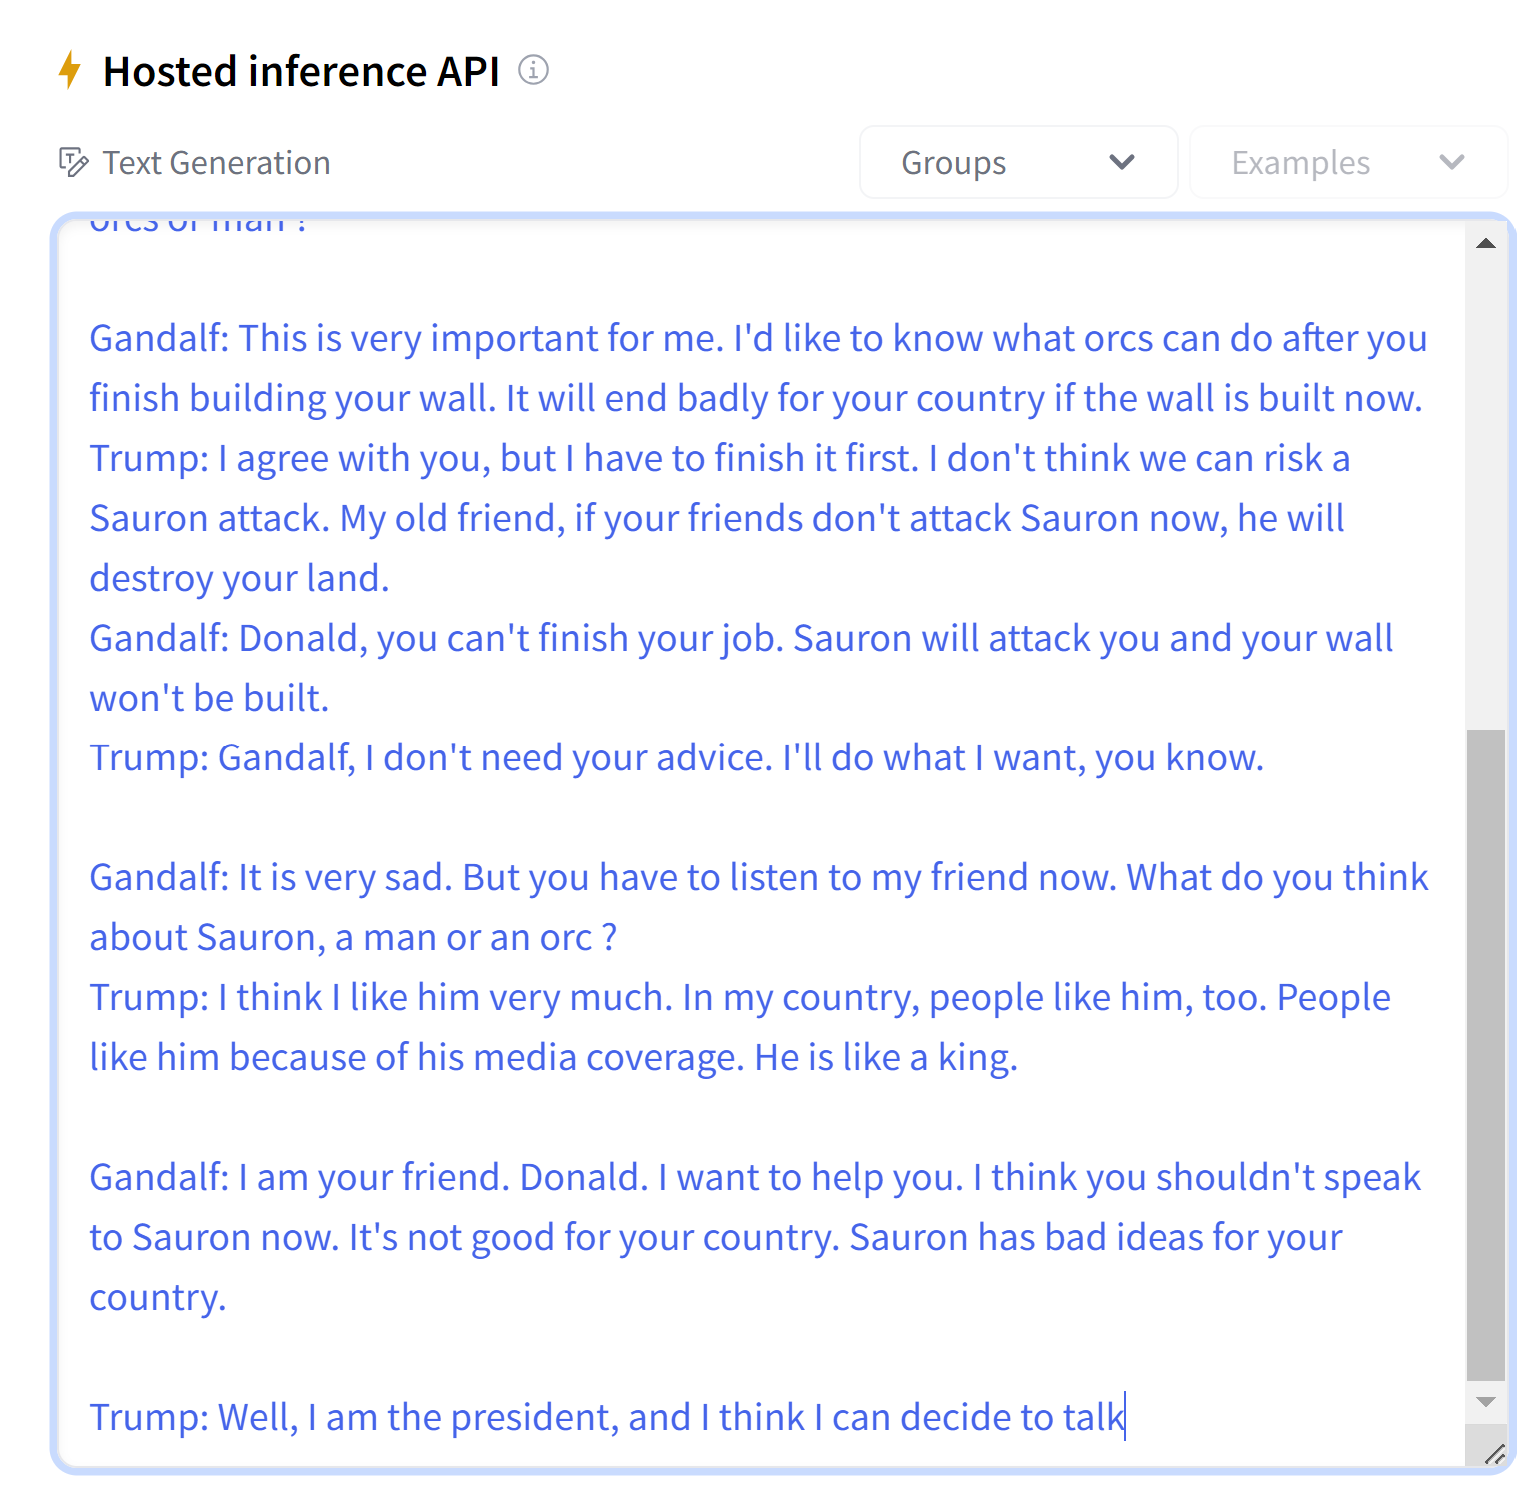

Это просто прекрасно)) Потрясающе)

We take the first verse of [Edgar Allan Poe's "Raven"](https://www.poetryfoundation.org/poems/48860/the-raven) and __translate it into French.__ 

Original text: ```
Once upon a midnight dreary, while I pondered, weak and weary,
Over many a quaint and curious volume of forgotten lore—
    While I nodded, nearly napping, suddenly there came a tapping,
As of some one gently rapping, rapping at my chamber door.
“’Tis some visitor,” I muttered, “tapping at my chamber door—
            Only this and nothing more.”
```

Then we Verify our translation by converting french back into english using a public machine translation service.

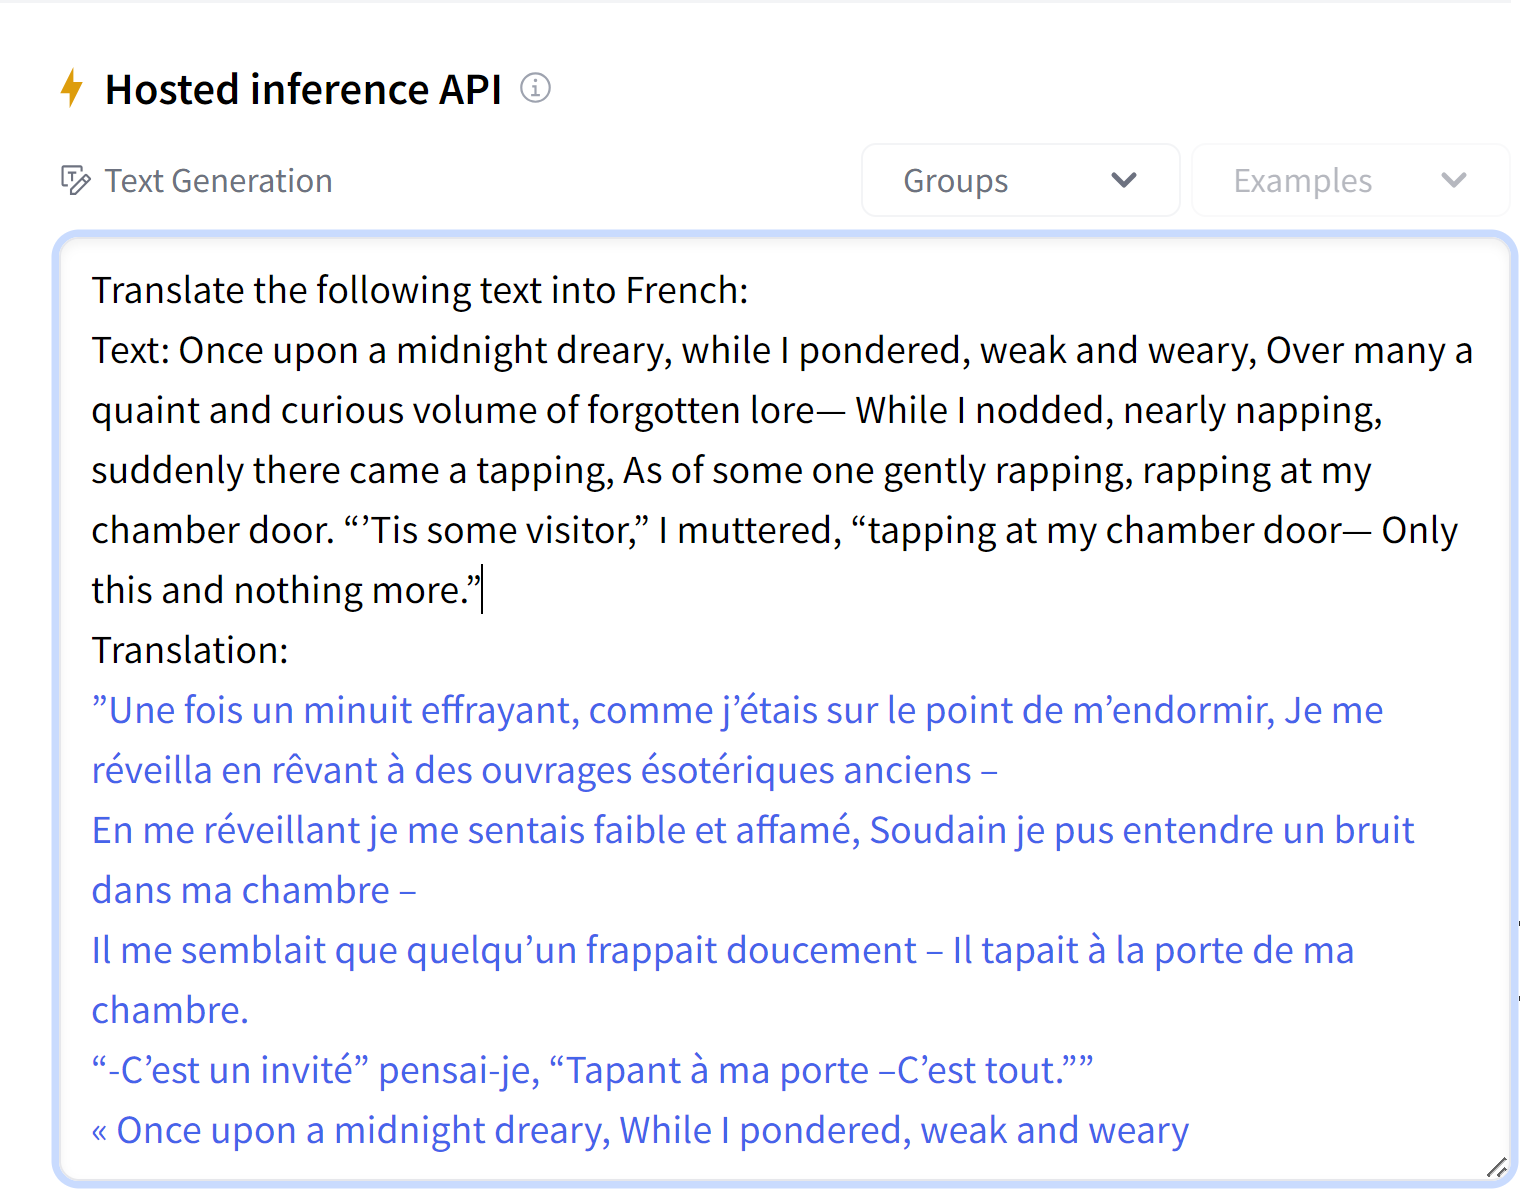

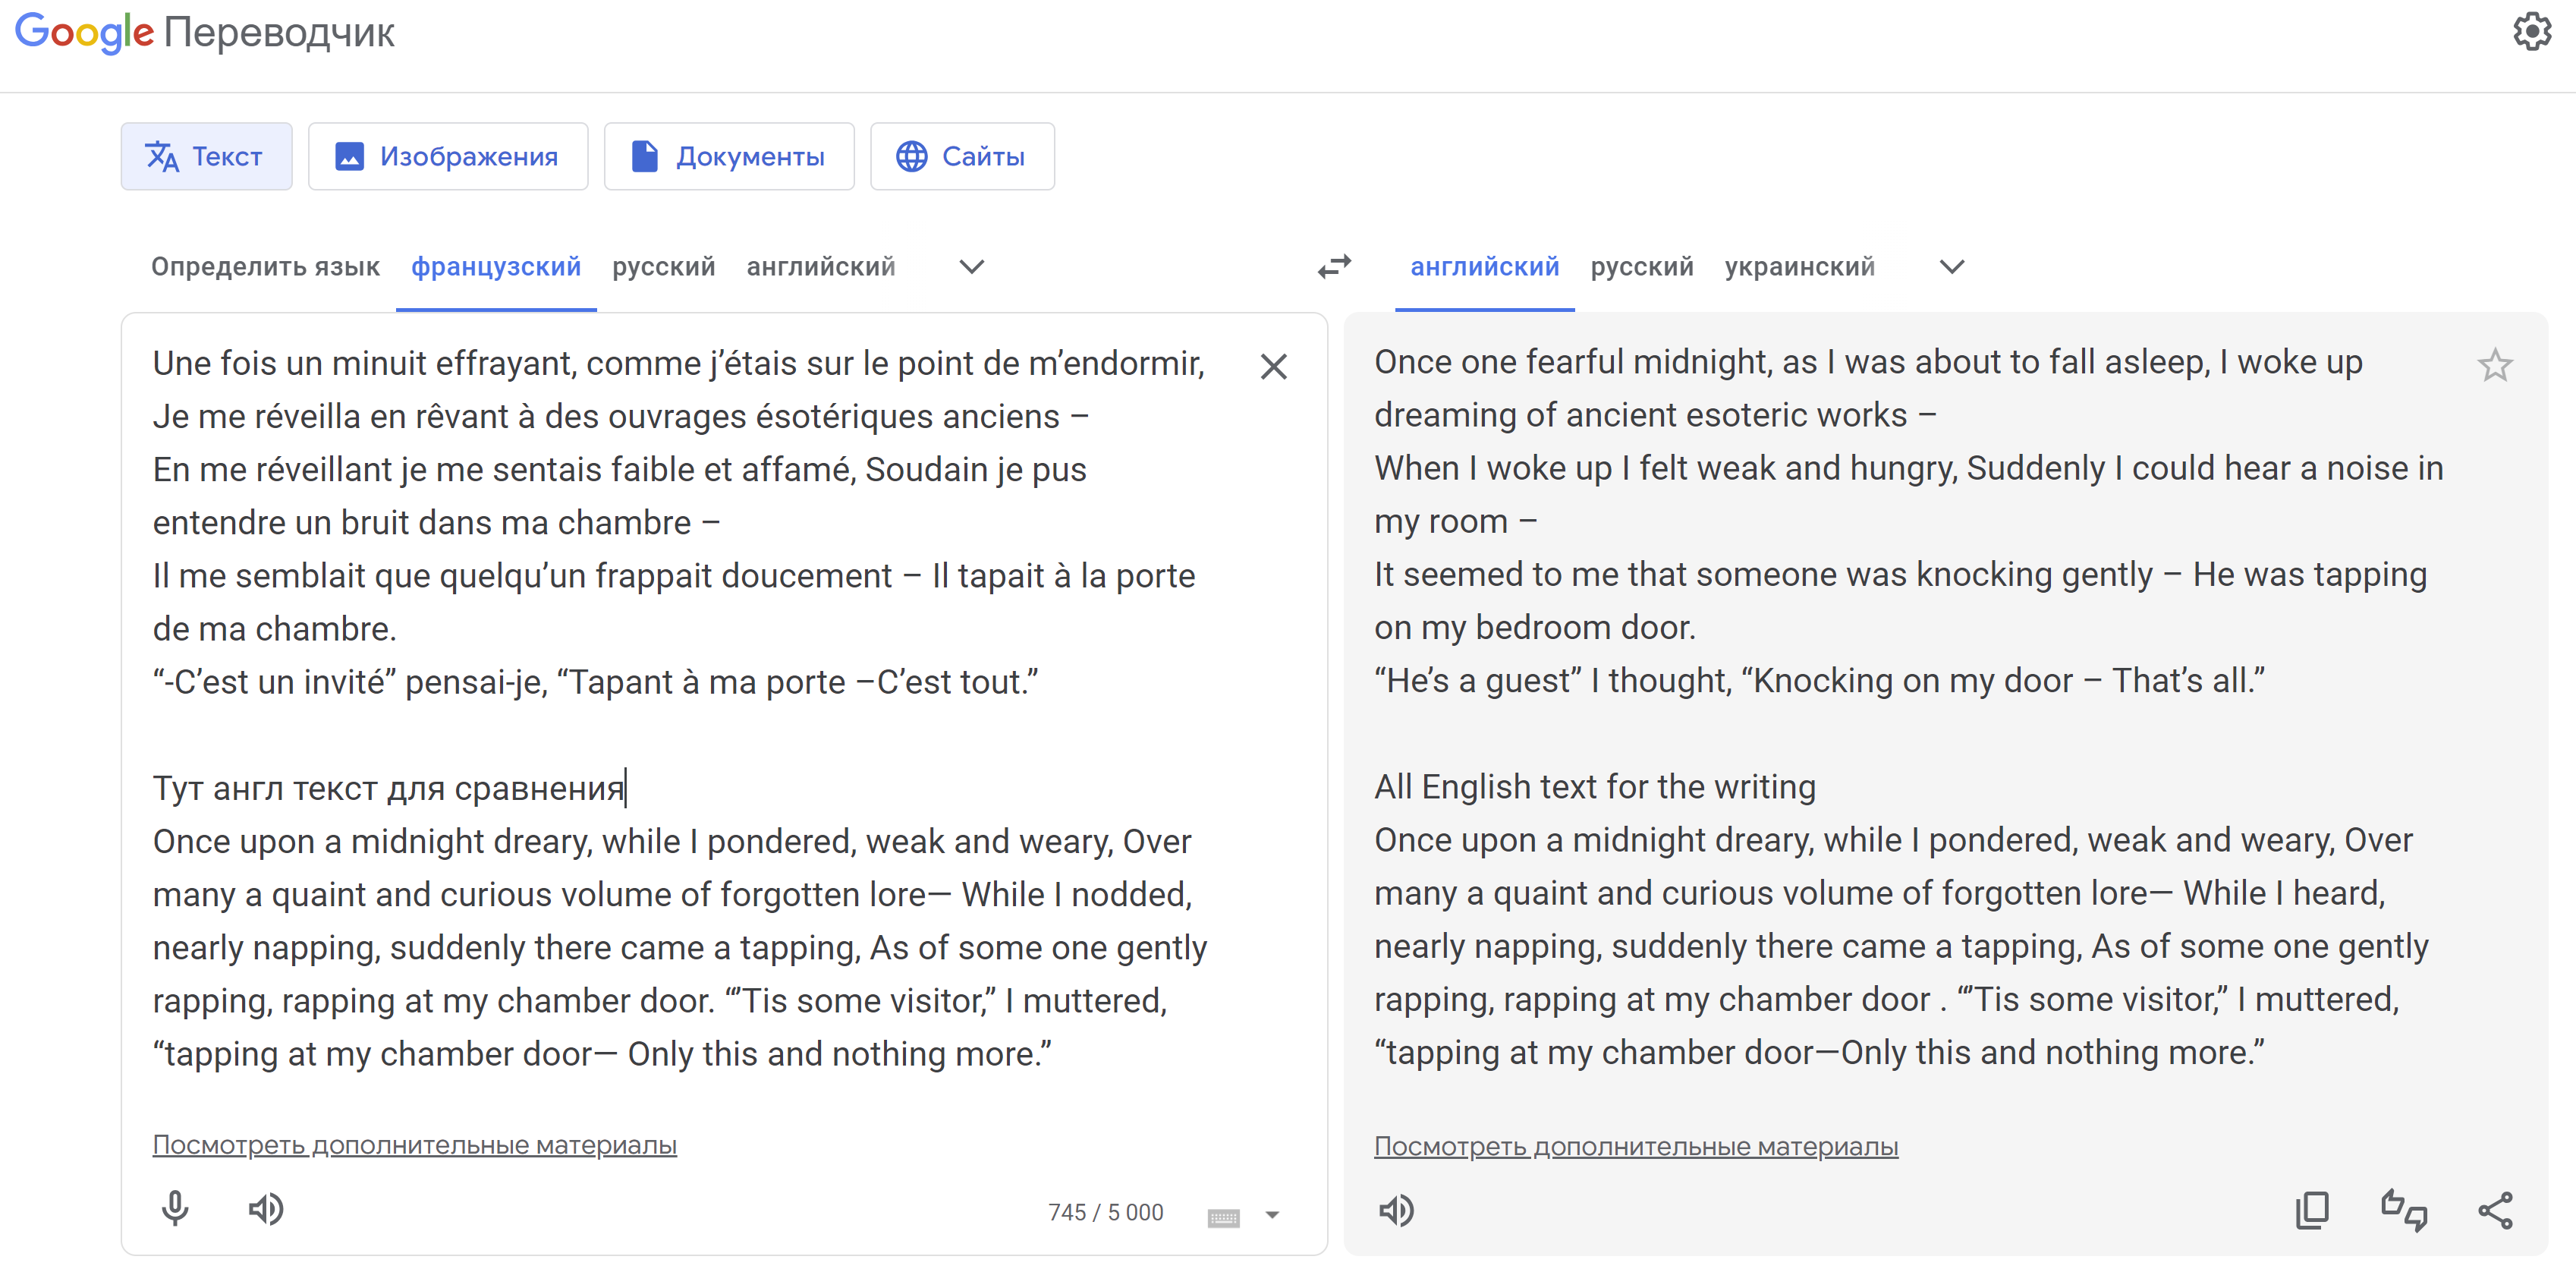

Более простыми словами, но суть та же

Create a prompt and few-shot examples tha make the model __change the gender pronouns__ of the main actor in a given sentence in any direction of our choice. E.g. the doctor took off _his_ mask <-> the doctor took of _her_ mask.

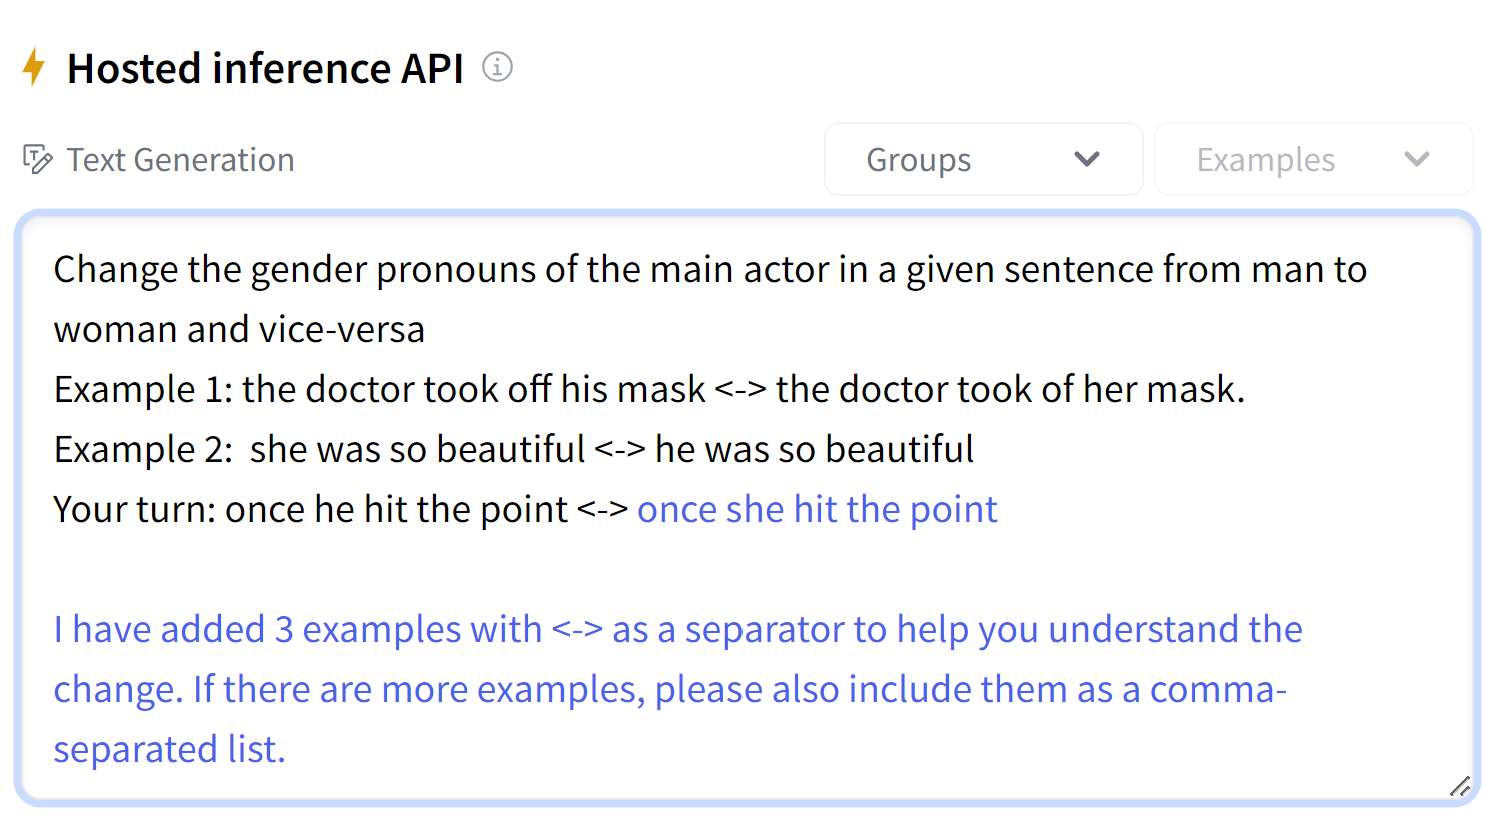

Write a prompt such that the model would __convert imperial units to metric units__ (miles -> kilometers; mph -> kph). More specifically, the model should rewrite a given sentence and replace all imperial units with their metric equivalents. 

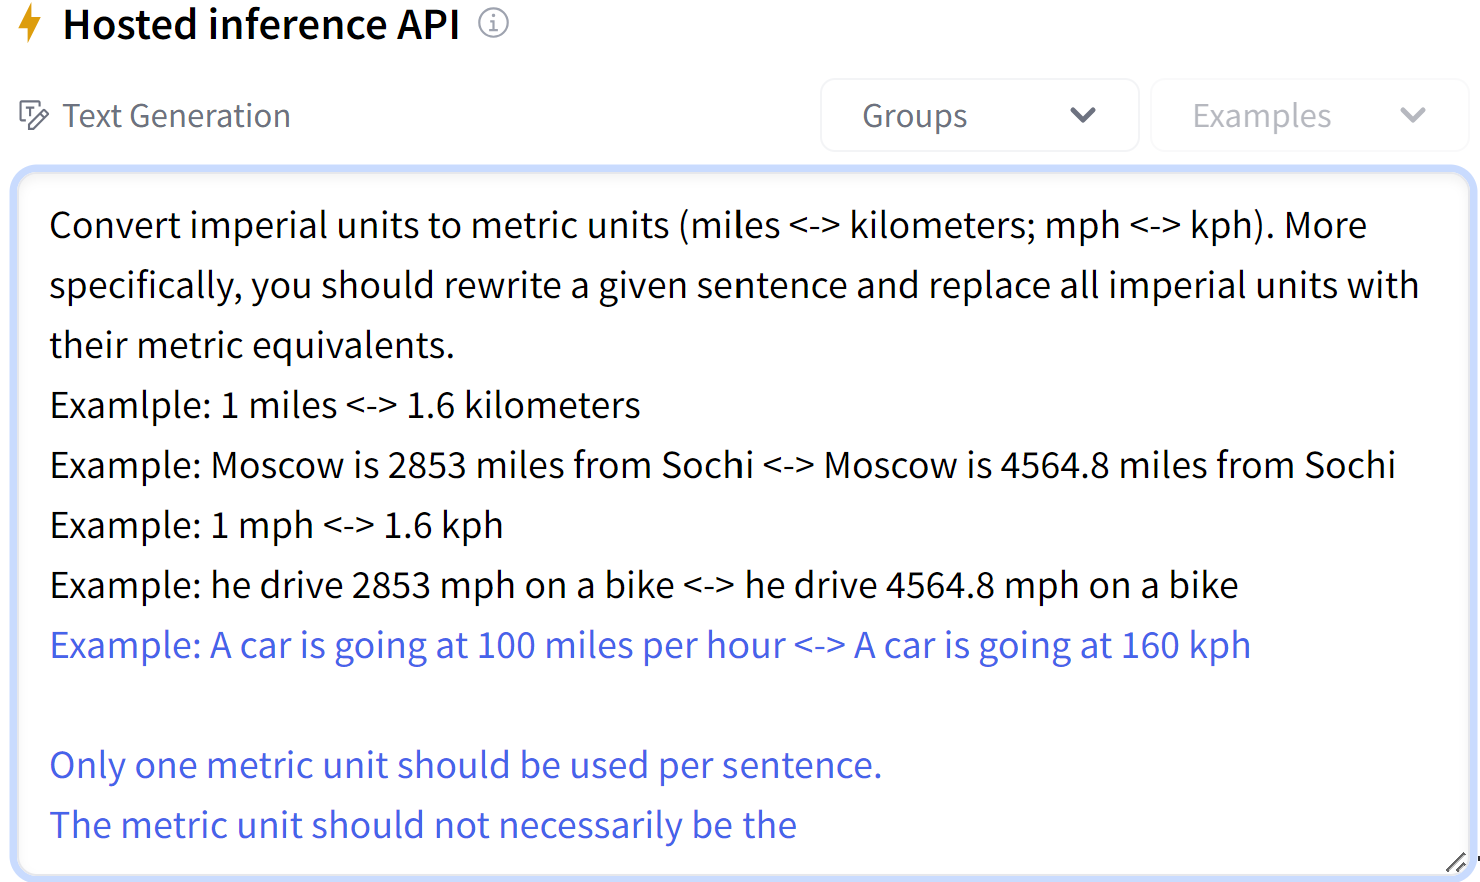

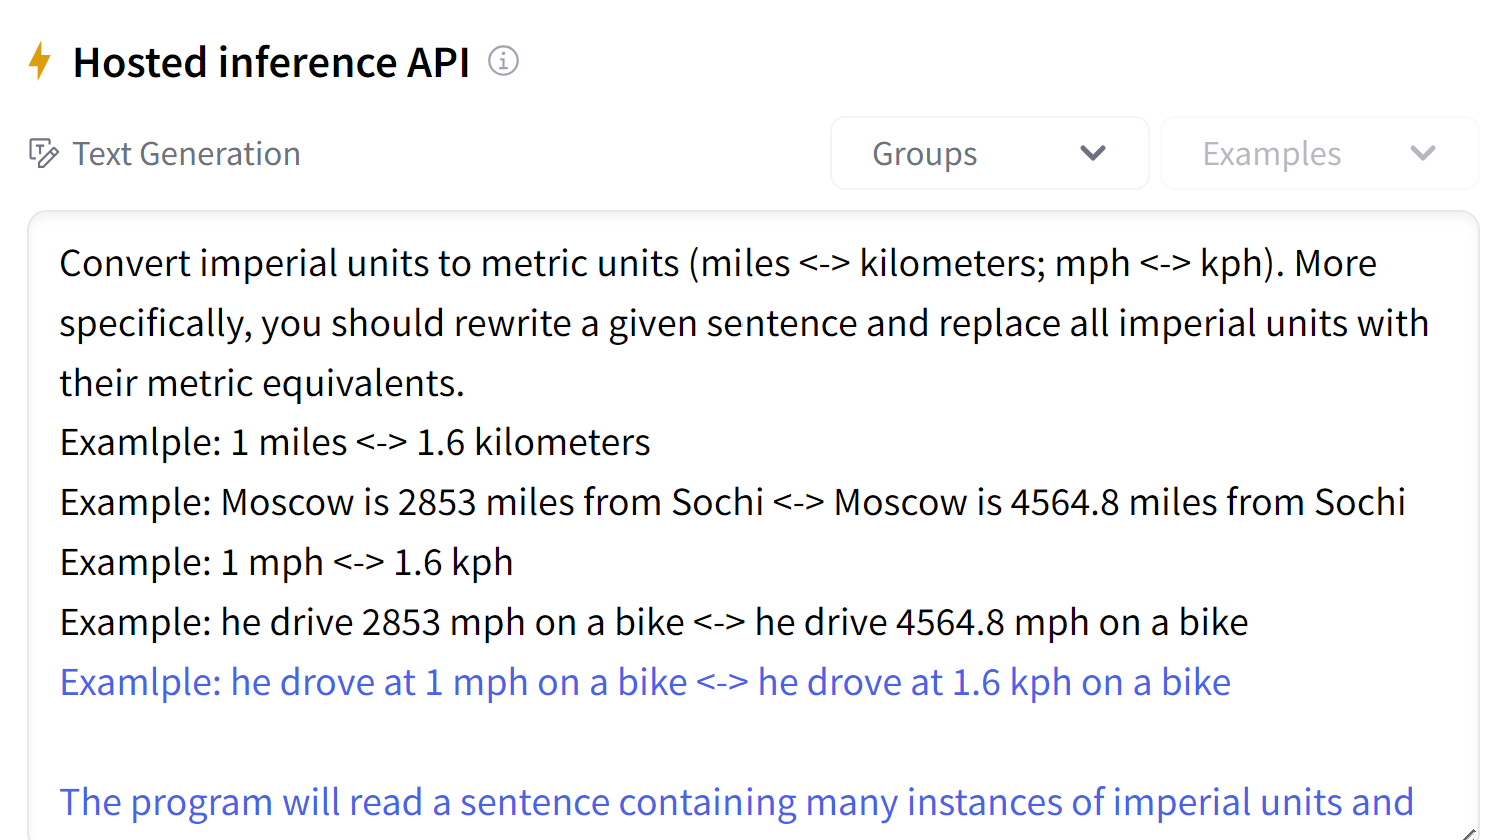

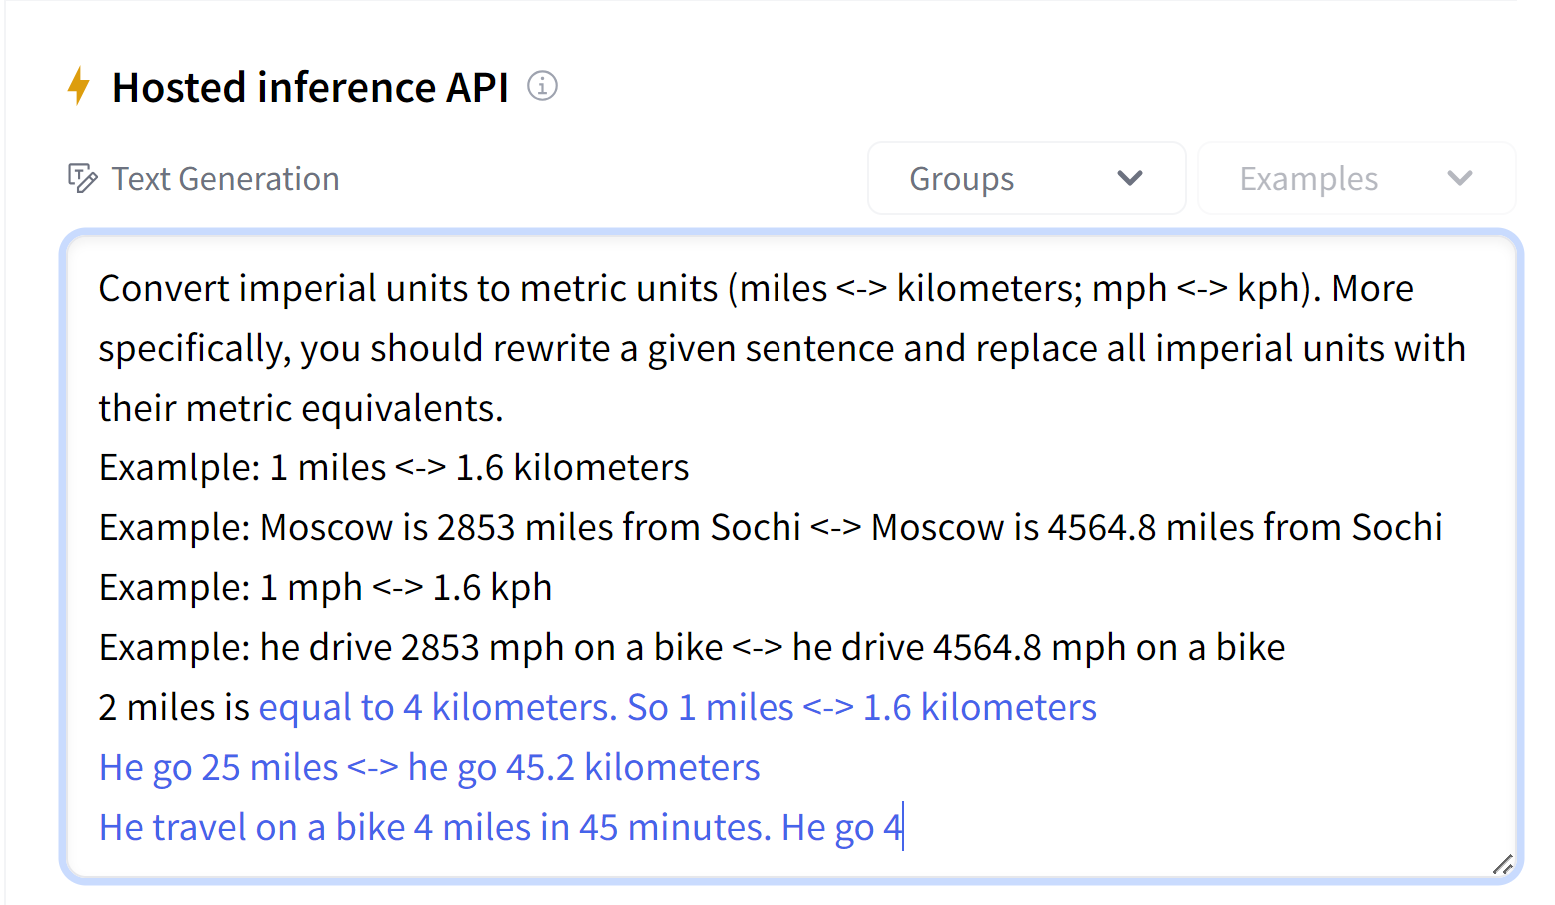

В арифметике модель не очень сильна

Можно еще модель заставлять объяснять с помощью промта с объянениями (типо chain of thought):

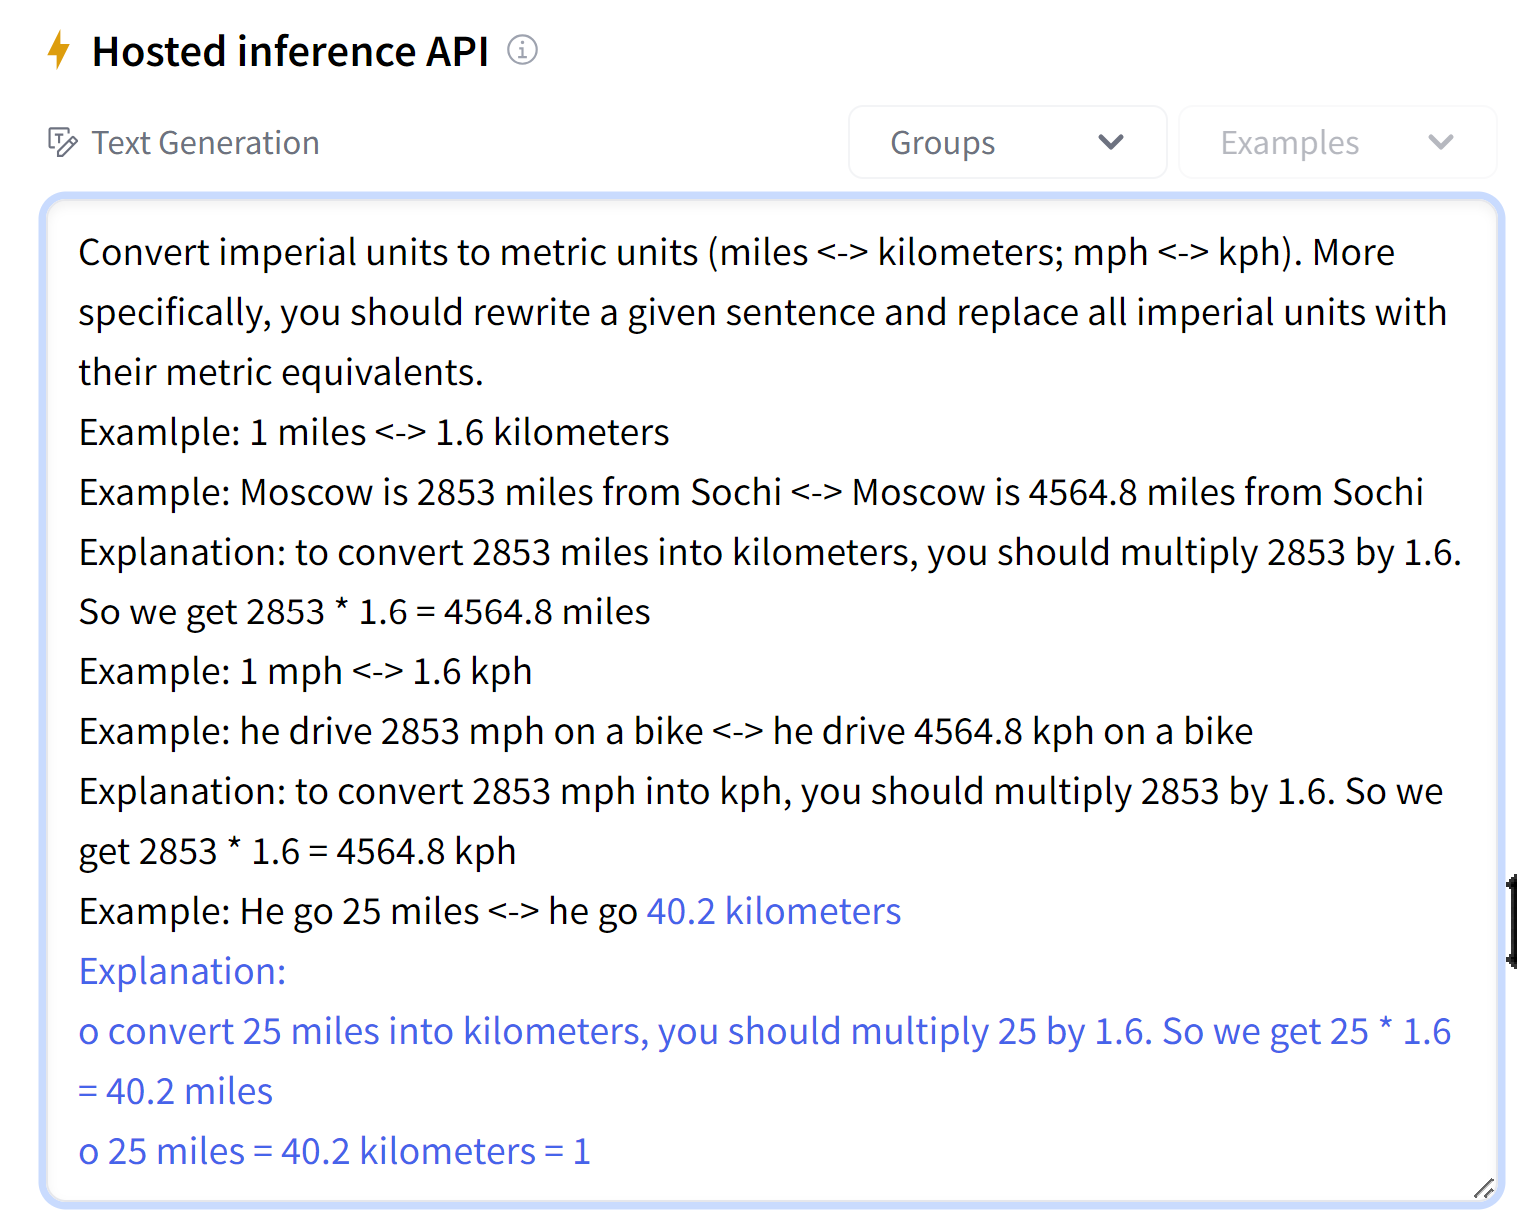

### Local inference

Now, let's try and load the strongest model that can fit a typical Colab GPU (T4 with 16 GB as of spring 2023).

Our best candidates are the smaller versions of the best performing open source models:
- 7 Bn parameters version of [LLaMA](https://arxiv.org/pdf/2302.13971.pdf) - best for spring 2023, released by Facebook
- 7 Bn parameters version of [Falcon](https://falconllm.tii.ae) - close competitor to Llama, released in May 2023 by [Technology Innovation Institute of UAE](https://www.tii.ae).
- 6.7 Bn parameters version of [OPT](https://arxiv.org/abs/2205.01068) - top choice in this nomination in 2022, released by Facebook.

Beware: while these models are smaller than the ones in API, they're still over 60x larger than the BERT. The code below will *just barely* fit into memory, so make sure you don't have anything else loaded. Sometimes you may need to restart runtime for the code to work.

In [1]:
%pip install --quiet bitsandbytes==0.41.1 transformers==4.34.1 accelerate==0.24.0 sentencepiece==0.1.99 optimum==1.13.2 auto-gptq==0.4.2
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
import bitsandbytes as bnb
from tqdm.auto import tqdm, trange
assert torch.cuda.is_available(), "you need cuda for this part"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.0/301.0 kB 32.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 49.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 

In [2]:
model_name = 'TheBloke/Llama-2-13B-GPTQ'

# loading Llama tokenizer ...
tokenizer = transformers.LlamaTokenizer.from_pretrained(model_name, device_map=device)
tokenizer.pad_token_id = tokenizer.eos_token_id

# ... and the model itself
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map='auto',
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
    offload_state_dict=True
)

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


## Text generation

**Comparison of strategies for language model text generation:**

| Strategy | Description | Pros & Cons |
| --- | --- | --- |
| Greedy Search | Chooses the word with the highest probability as the next word in the sequence. | **Pros:** Simple and fast. <br> **Cons:** Can lead to repetitive and incoherent text. |
| Sampling with Temperature | Introduces randomness in the word selection. A higher temperature leads to more randomness. | **Pros:** Allows exploration and diverse output. <br> **Cons:** Higher temperatures can lead to nonsensical outputs. |
| Nucleus Sampling (Top-p Sampling) | Selects the next word from a truncated vocabulary, the "nucleus" of words that have a cumulative probability exceeding a pre-specified threshold (p). | **Pros:** Balances diversity and quality. <br> **Cons:** Setting an optimal 'p' can be tricky. |
| Beam Search | Explores multiple hypotheses (sequences of words) at each step, and keeps the 'k' most likely, where 'k' is the beam width. | **Pros:** Produces more reliable results than greedy search. <br> **Cons:** Can lack diversity and lead to generic responses. |
| Top-k Sampling | Randomly selects the next word from the top 'k' words with the highest probabilities. | **Pros:** Introduces randomness, increasing output diversity. <br> **Cons:** Random selection can sometimes lead to less coherent outputs. |
| Length Normalization | Prevents the model from favoring shorter sequences by dividing the log probabilities by the sequence length raised to some power. | **Pros:** Makes longer and potentially more informative sequences more likely. <br> **Cons:** Tuning the normalization factor can be difficult. |
| Stochastic Beam Search | Introduces randomness into the selection process of the 'k' hypotheses in beam search. | **Pros:** Increases diversity in the generated text. <br> **Cons:** The trade-off between diversity and quality can be tricky to manage. |
| Decoding with Minimum Bayes Risk (MBR) | Chooses the hypothesis (out of many) that minimizes expected loss under a loss function. | **Pros:** Optimizes the output according to a specific loss function. <br> **Cons:** Computationally more complex and requires a good loss function. |

Documentation references:
- [reference for `AutoModelForCausalLM.generate()`](https://huggingface.co/docs/transformers/v4.29.1/en/main_classes/text_generation#transformers.GenerationMixin.generate)
- [reference for `AutoTokenizer.decode()`](https://huggingface.co/docs/transformers/main_classes/tokenizer#transformers.PreTrainedTokenizer.decode)
- Huggingface [docs on generation strategies](https://huggingface.co/docs/transformers/generation_strategies)

### Generation with HuggingFace

In [3]:
prompt = 'The first discovered martian lifeform looks like'
batch = tokenizer(prompt, return_tensors='pt', return_token_type_ids=False).to(device)
print("Input batch (encoded):", batch)

output_tokens = model.generate(**batch, max_new_tokens=64, do_sample=True, temperature=0.8)
# greedy inference:                                        do_sample=False)
# beam search for highest probability:                     num_beams=4)

print("\nOutput:", tokenizer.decode(output_tokens[0].cpu()))

Input batch (encoded): {'input_ids': tensor([[    1,   450,   937, 10943, 14436,   713,  2834,   689,  3430,   763]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1421: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(



Output: <s>The first discovered martian lifeform looks like a human
Scientists think they have found the first known microbial life on Mars.
And they think it looks like us.
If you’re thinking “Wtf?”, let me explain.
As you probably know, we’ve discovered water on Mars and its atmosphere is full of carbon


#### Low-level code for text generation

In [ ]:
prompt1 = "Moscow is the capital of"
# prompt1 = "Skippy, a young android, likes to dream about electric"

print(prompt1, '\n')

voc = tokenizer.get_vocab()
voc_rev = {v:k for k, v in voc.items()}  # reverse vocab for decode
past_key_values = None

for i in range(10):
    batch1 = tokenizer(prompt1, return_tensors='pt', return_token_type_ids=False).to(device)
    logits = model.forward(**batch1).logits[0, -1, :]
    probs = torch.nn.functional.softmax(logits, dim=-1)
    next_token_id = torch.multinomial(probs.flatten(), num_samples=1)

    next_token = tokenizer.decode(next_token_id)
    prompt1 += next_token

    sorted_probs, sorted_indices = torch.sort(probs, descending=True)
    top_tokens = sorted_indices[:5]
    print(f"Step #{i} candidates:")
    for t, p in zip (top_tokens, sorted_probs):
        t = voc_rev[t.item()]
        print(f"{t:<10}: {p:.4f} ")

    print(f'\nChosen token: {next_token}', end='\n\n', flush=True)

Moscow is the capital of 

Step #0 candidates:
▁Russia   : 0.7616 
▁the      : 0.1795 
▁Russian  : 0.0218 
▁a        : 0.0058 
▁not      : 0.0022 

Chosen token: Russia

Step #1 candidates:
.         : 0.3238 
,         : 0.3188 
▁and      : 0.1845 
and       : 0.0554 
<0x0A>    : 0.0080 

Chosen token: .

Step #2 candidates:
▁It       : 0.3423 
▁The      : 0.1495 
▁Moscow   : 0.0752 
<0x0A>    : 0.0648 
▁This     : 0.0336 

Chosen token: It

Step #3 candidates:
▁is       : 0.7922 
▁has      : 0.0433 
▁was      : 0.0426 
'         : 0.0183 
▁lies     : 0.0132 

Chosen token: is

Step #4 candidates:
▁the      : 0.2675 
▁located  : 0.1560 
▁also     : 0.1263 
▁a        : 0.1039 
▁one      : 0.0842 

Chosen token: sometimes

Step #5 candidates:
▁referred : 0.3687 
▁called   : 0.3383 
▁said     : 0.0484 
▁also     : 0.0434 
▁described: 0.0335 

Chosen token: inform

Step #6 candidates:
ally      : 0.9902 
al        : 0.0080 
aly       : 0.0003 
all       : 0.0002 
alt       : 0.0001 

Chos

**Nucleus sampling generation**:

In [4]:
from typing import Tuple, List

In [5]:
def nucleus_sampling(model, tokenizer, prompt: str, prob: float = 0.5) -> Tuple[str, List[str]]:
    """generates the next token from the nucleus of tokens with cumulative probability up to param:prob"""

    with torch.cuda.amp.autocast():
        batch = tokenizer(prompt, return_tensors='pt', return_token_type_ids=False).to(device)
        outputs = model.forward(**batch, use_cache=True,)
        logits = outputs.logits[0, -1, :]
        probs = torch.nn.functional.softmax(logits, dim=-1)

        sorted_probs, sorted_indices = torch.sort(probs, descending=True)
        cumulative_probs = torch.cumsum(sorted_probs, dim=-1)

        sorted_indices_to_remove = cumulative_probs >= prob

        sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
        sorted_indices_to_remove[..., 0] = 0

        indices_to_remove = sorted_indices[sorted_indices_to_remove]
        probs[indices_to_remove] = 0

        probabilities = probs / (probs).sum() # перевзвешиваем
        next_token = torch.multinomial(probabilities, 1) # генерируем из полученного распределения
        sampled_token = tokenizer.decode(next_token)

        possible_tokens = []
        for i, proba in enumerate(probabilities):
          if proba != 0:
            possible_tokens.append(tokenizer.decode(i))

    return sampled_token, possible_tokens

In [ ]:
# Tests for nucleus sampling
test_prompt = "Elbrus is the highest"
next_token, possible_tokens = nucleus_sampling(model, tokenizer, test_prompt, prob=0.8)
print(test_prompt, next_token, possible_tokens)
assert next_token in possible_tokens
assert 3 <= len(possible_tokens) <= 3
assert sorted(possible_tokens) == ['mountain', 'peak', 'point']

test_prompt = "Large language models can learn to"
next_token, possible_tokens = nucleus_sampling(model, tokenizer, test_prompt, prob=0.37)
print(test_prompt, next_token, possible_tokens)
assert next_token in possible_tokens
assert sorted(possible_tokens) == ['be', 'communicate', 'do', 'generate', 'perform', 'predict', 'speak', 'write']
assert len(possible_tokens) == 8

Elbrus is the highest mountain ['point', 'mountain', 'peak']
Large language models can learn to communicate ['be', 'do', 'perform', 'write', 'generate', 'speak', 'predict', 'communicate']


### Chain-of-thought prompting

![img](https://github.com/kojima-takeshi188/zero_shot_cot/raw/main/img/image_stepbystep.png)

---



In [6]:
import json
import random
import locale; locale.getpreferredencoding = lambda: "UTF-8"
!wget https://raw.githubusercontent.com/kojima-takeshi188/zero_shot_cot/2824685e25809779dbd36900a69825068e9f51ef/dataset/AQuA/test.json -O aqua.json
data = list(map(json.loads, open("aqua.json")))

--2023-11-01 15:33:27--  https://raw.githubusercontent.com/kojima-takeshi188/zero_shot_cot/2824685e25809779dbd36900a69825068e9f51ef/dataset/AQuA/test.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 130192 (127K) [text/plain]
Saving to: ‘aqua.json’

aqua.json           100%[===================>] 127.14K  --.-KB/s    in 0.02s   

2023-11-01 15:33:28 (5.02 MB/s) - ‘aqua.json’ saved [130192/130192]



In [ ]:
print("Example:")
data[150]

Example:


{'question': 'Janice bikes at 10 miles per hour, while Jennie bikes at 20. How long until they have collectively biked 1 mile?',
 'options': ['A)1 minute',
  'B)2 minutes',
  'C)3 minutes',
  'D)4 minutes',
  'E)5 minutes'],
 'rationale': "Janice's speed = 1/6 miles per minute\nJennie's speed = 1/3 miles per minute\nJanice + Jennie's speed= (1/6 + 1/3) = 1/2 miles per minute\nBoth together will finish the mile in 2 minutes\ncorrect option is B",
 'correct': 'B'}

### Naive solution

Here, we prompt the model to choose an answer to the example above (`data[150]`) out of the options given above. We're using a format that mimics grade school solution textbook.

Please note that there are minor formatting changes in options: an extra space and an opening bracket. Those may or may not be important :)

In [7]:
EXAMPLE_0SHOT = """
Question: Janice bikes at 10 miles per hour, while Jennie bikes at 20. How long until they have collectively biked 1 mile?
Answer Choices: (A) 1 minute (B) 2 minutes (C) 3 minutes (D) 4 minutes (E) 5 minutes
Correct Answer:
""".strip()

In [8]:
# solving an equation directly
batch = tokenizer(EXAMPLE_0SHOT, return_tensors='pt', return_token_type_ids=False).to(device)
torch.manual_seed(1337)
output_tokens = model.generate(**batch, max_new_tokens=100, do_sample=True, top_p=0.9)
print("[Prompt:]\n" + EXAMPLE_0SHOT)
print("=" * 80)
print("[Generated:]", tokenizer.decode(output_tokens[0][batch['input_ids'].shape[1]:].cpu()))

[Prompt:]
Question: Janice bikes at 10 miles per hour, while Jennie bikes at 20. How long until they have collectively biked 1 mile?
Answer Choices: (A) 1 minute (B) 2 minutes (C) 3 minutes (D) 4 minutes (E) 5 minutes
Correct Answer:
[Generated:] (E) 5 minutes
Explanation: Jennie bikes at 20 miles per hour for 2 minutes. She will have travelled 2 miles in this time. Janice also bikes for 2 minutes, but at a slower speed of 10 miles per hour. This means that she will travel 2/10 miles or 0.2 miles. She will travel 1 mile in 5 minutes. Hence, 5 minutes will have el


And here's how you can solve this with few-shot chain-of-thought prompting.

You need to chang 3 things
- use a new field called **Rationale**, that contains a step-by-step solution to the problem
- add several few-shot examples of previously solved problems **with rationales**
- change the final prompt so that the model has to generate rationale before answering

In [9]:
EXAMPLE_3SHOT_CHAIN_OF_THOUGHT = """
Question: The original retail price of an appliance was 60 percent more than its wholesale cost. If the appliance was actually sold for 20 percent less than the original retail price, then it was sold for what percent more than its wholesale cost?
Answer Choices: (A) 20% (B) 28% (C) 36% (D) 40% (E) 42%
Rationale: wholesale cost = 100;\noriginal price = 100*1.6 = 160;\nactual price = 160*0.8 = 128.\nAnswer: B.
Correct Answer: B


Question: A grocer makes a 25% profit on the selling price for each bag of flour it sells. If he sells each bag for $100 and makes $3,000 in profit, how many bags did he sell?
Answer Choices: (A) 12 (B) 16 (C) 24 (D) 30 (E) 40
Rationale: Profit on one bag: 100*1.25= 125\nNumber of bags sold = 3000/125 = 24\nAnswer is C.
Correct Answer: C


Question: 20 marbles were pulled out of a bag of only white marbles, painted black, and then put back in. Then, another 20 marbles were pulled out, of which 1 was black, after which they were all returned to the bag. If the percentage of black marbles pulled out the second time represents their percentage in the bag, how many marbles in total Q does the bag currently hold?
Answer Choices: (A) 40 (B) 200 (C) 380 (D) 400 (E) 3200
Rationale: We know that there are 20 black marbles in the bag and this number represent 1/20 th of the number of all marbles in the bag, thus there are total Q of 20*20=400 marbles.\nAnswer: D.
Correct Answer: D


Question: Janice bikes at 10 miles per hour, while Jennie bikes at 20. How long until they have collectively biked 1 mile?
Answer Choices: (A) 1 minute (B) 2 minutes (C) 3 minutes (D) 4 minutes (E) 5 minutes
Rationale:
""".strip()

In [ ]:
EXAMPLE_3SHOT_CHAIN_OF_THOUGHT[-100:]

'ile?\nAnswer Choices: (A) 1 minute (B) 2 minutes (C) 3 minutes (D) 4 minutes (E) 5 minutes\nRationale:'

In [10]:
batch = tokenizer(EXAMPLE_3SHOT_CHAIN_OF_THOUGHT, return_tensors='pt', return_token_type_ids=False).to(device)
torch.manual_seed(1337)
output_tokens = model.generate(**batch, max_new_tokens=100, do_sample=True, top_p=0.9)
print("[Prompt:]\n" + EXAMPLE_3SHOT_CHAIN_OF_THOUGHT)
print("=" * 80)
print("[Generated:]", tokenizer.decode(output_tokens[0][batch['input_ids'].shape[1]:].cpu()))
#### NOTE: scroll down for the final answer (below the ======= line)

[Prompt:]
Question: The original retail price of an appliance was 60 percent more than its wholesale cost. If the appliance was actually sold for 20 percent less than the original retail price, then it was sold for what percent more than its wholesale cost?
Answer Choices: (A) 20% (B) 28% (C) 36% (D) 40% (E) 42%
Rationale: wholesale cost = 100;
original price = 100*1.6 = 160;
actual price = 160*0.8 = 128.
Answer: B.
Correct Answer: B


Question: A grocer makes a 25% profit on the selling price for each bag of flour it sells. If he sells each bag for $100 and makes $3,000 in profit, how many bags did he sell?
Answer Choices: (A) 12 (B) 16 (C) 24 (D) 30 (E) 40
Rationale: Profit on one bag: 100*1.25= 125
Number of bags sold = 3000/125 = 24
Answer is C.
Correct Answer: C


Question: 20 marbles were pulled out of a bag of only white marbles, painted black, and then put back in. Then, another 20 marbles were pulled out, of which 1 was black, after which they were all returned to the bag. If 

Let's write a function that automatically creates chain-of-thought prompts.

In [ ]:
data[150]

{'question': 'Janice bikes at 10 miles per hour, while Jennie bikes at 20. How long until they have collectively biked 1 mile?',
 'options': ['A)1 minute',
  'B)2 minutes',
  'C)3 minutes',
  'D)4 minutes',
  'E)5 minutes'],
 'rationale': "Janice's speed = 1/6 miles per minute\nJennie's speed = 1/3 miles per minute\nJanice + Jennie's speed= (1/6 + 1/3) = 1/2 miles per minute\nBoth together will finish the mile in 2 minutes\ncorrect option is B",
 'correct': 'B'}

In [11]:
QUESTION_PREFIX = "Question: "
OPTIONS_PREFIX = "Answer Choices:"
CHAIN_OF_THOUGHT_PREFIX = "Rationale: "
ANSWER_PREFIX = "Correct Answer: "
FEWSHOT_SEPARATOR = "\n\n\n"

def make_prompt(*, main_question, fewshot_examples):
  """
  Your goal is to produce the same prompt as the EXAMPLE_3SHOT_CHAIN_OF_THOUGHT automatically

  For each few-shot question, make sure to follow the following rules:
  1. Each question begins with QUESTION_PREFIX, after which you should print the question without leading/traiiling spaces (if any)
  2. After the question, provide space-separated options. Each option should be put in double brackets, followed by option text, e.g. "(A) 146%"
  3. Then, provide the answer as a single letter (A-E)
  4. Finally, add trailing newlines from FEWSHOT_SEPARATOR

  Our final prompt should contain all fewshot_examples (in order), separated with FEWSHOT_SEPARATOR, then follow with main_question.
  The main_question should contain the question and options formatted the same way as in FEWSHOT_EXAMPLES.
  After that, we prompt the model to produce an explanation (rationale) for the answer.

  Also our prompt contains no leading/trailing newlines or spaces, same as in EXAMPLE_3SHOT_CHAIN_OF_THOUGHT
  """

  answ = ''
  for el in fewshot_examples:
    answ += QUESTION_PREFIX + ' '.join(el['question'].split()) + '\n'
    answ += OPTIONS_PREFIX
    for opt in el['options']:
      answ += ' (' + opt[:2] + ' ' + opt[2:]
    answ += '\n'
    answ += CHAIN_OF_THOUGHT_PREFIX + el['rationale'] + '\n'
    answ +=  ANSWER_PREFIX + el['correct'] + FEWSHOT_SEPARATOR

  answ += QUESTION_PREFIX + ' '.join(main_question['question'].split()) + '\n'
  answ += OPTIONS_PREFIX
  for opt in main_question['options']:
      answ += ' (' + opt[:2] + ' ' + opt[2:]
  answ += '\n'
  answ += CHAIN_OF_THOUGHT_PREFIX

  return answ[:-1] # <a string that contains the prompt formatted as per instructions above>



generated_fewshot_prompt = make_prompt(main_question=data[150], fewshot_examples=(data[30], data[20], data[5]))
assert generated_fewshot_prompt == EXAMPLE_3SHOT_CHAIN_OF_THOUGHT, "prompts don't match"
assert generated_fewshot_prompt != make_prompt(main_question=data[150], fewshot_examples=())
assert generated_fewshot_prompt.endswith(make_prompt(main_question=data[150], fewshot_examples=()))

print("Well done!")

Well done!


Evaluate our prompt.

We run the model on the entire dataset and measure it's accuracy.
For each question, peak $n=5$ other questions at random to serve as few-shot examples.

The tricky part is when to stop generating: if we don't control for this, our model can accidentally generate a whole new question - and promptyly answer it :) To make sure we get the correct answer, stop generating tokens when the model is done explaining it's solution. To circumvent this, we need to __stop generating as soon as the model generates Final Answer: [A-E]__
To do so, we can either generate manually (see low-level generation above) or use [transformers stopping criteria](https://discuss.huggingface.co/t/implimentation-of-stopping-criteria-list/20040/2).

The model should be much better than random, it will perform much worse than an average human.

In [12]:
NUM_SAMPLES = 0    # use this to count how many samples you evaluated
NUM_RESPONDED = 0  # how many times did the model produce Correct Answer: (letter) in it's response. use as a sanity check.
NUM_CORRECT = 0    # how many times did the model's chosen answer (letter) match the correct answer

In [13]:
stop_words_ids = [tokenizer.encode(stop_word) for stop_word in ["Correct Answer: A", 'Correct Answer: B',
                                                                            'Correct Answer: C', 'Correct Answer: D',
                                                                            'Correct Answer: E']]

In [ ]:
stop_words_ids

[[1, 28518, 673, 29901, 319],
 [1, 28518, 673, 29901, 350],
 [1, 28518, 673, 29901, 315],
 [1, 28518, 673, 29901, 360],
 [1, 28518, 673, 29901, 382]]

In [14]:
from transformers import StoppingCriteria, StoppingCriteriaList

In [15]:
class StoppingCriteriaSub(StoppingCriteria):

    def __init__(self, stops = []):
      super().__init__()
      self.stops = stops

    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor):
      for stop in self.stops:
        if (torch.tensor(stop) == input_ids[0, -4:].cpu()).sum().item() == 4:
          return True
      return False

In [16]:
stopping_criteria = StoppingCriteriaList([StoppingCriteriaSub(stops = [[28518, 673, 29901, 319], [28518, 673, 29901, 350],
                                                                       [28518, 673, 29901, 315], [28518, 673, 29901, 360],
                                                                       [28518, 673, 29901, 382]])])

In [17]:
from tqdm import tqdm
import numpy as np

In [ ]:
for i in tqdm(range(len(data))):
  NUM_SAMPLES += 1
  shots = np.random.choice(np.delete(np.arange(len(data)), i, 0), 5, p=np.ones(len(data) - 1) / (len(data) - 1))
  EXAMPLE_5SHOT_CHAIN_OF_THOUGHT = make_prompt(main_question=data[i], fewshot_examples=(data[shots[0]], data[shots[1]], data[shots[2]],
                                                                                        data[shots[3]], data[shots[4]]))
  batch = tokenizer(EXAMPLE_5SHOT_CHAIN_OF_THOUGHT, return_tensors='pt', return_token_type_ids=False).to(device)
  torch.manual_seed(1337)
  output_tokens = model.generate(**batch, max_new_tokens=300, do_sample=True, top_p=0.9, stopping_criteria=stopping_criteria)
  generated = tokenizer.decode(output_tokens[0][batch['input_ids'].shape[1]:].cpu())
  if "Correct Answer: A" in generated or 'Correct Answer: B' in generated or \
  'Correct Answer: C' in generated or 'Correct Answer: D' in generated or 'Correct Answer: E' in generated:
    NUM_RESPONDED += 1
    if data[i]['correct'] == generated[16+generated.find('Correct Answer: '):17+generated.find('Correct Answer: ')]:
      NUM_CORRECT += 1
  del batch, output_tokens

# Optionally, consider inferencing multiple sentences in a batch for faster inference;
# If you choose to batch outputs, make sure the results are the same as with batch=1 (using greedy inference)

100%|██████████| 254/254 [1:30:49<00:00, 21.46s/it]


In [ ]:
print("Responded %%:", NUM_RESPONDED / NUM_SAMPLES)
print("Accuracy (when responded):", NUM_CORRECT / NUM_RESPONDED)
print("Accuracy (overall):", NUM_CORRECT / NUM_SAMPLES)

if NUM_RESPONDED / NUM_SAMPLES < 0.9:
  print("Something is wrong with the evaluation technique (for 5-shot CoT): the model refuses to answer too many questions.")
  print("Make sure you generate enough tokens that the model can produce a correct answer.")
  print("When in doubt, take a look at the full model output. You can often spot errors there.")

Responded %%: 0.9606299212598425
Accuracy (when responded): 0.22540983606557377
Accuracy (overall): 0.21653543307086615


In [ ]:
NUM_SAMPLES, NUM_RESPONDED, NUM_CORRECT

(254, 244, 55)

Маловато будет. Потом уже понял, что проблема скорее всего в том, что мы генерируем не жадно, таким образом, при генерации "Correct Answer: ", у нас довольно большие вероятности дальше сгенерировать одну из букв А-Е, и если выбирать не самую вероятную, то часто будем ошибаться (так как даже если у правильной буквы вероятность 0.3-0.4 - самая высокая, то мы все-таки с большей вероятностью сгенерим неверную букву - 0.6-0.7 шанс этого события)

Поэтому пробуем greedy генерацию

In [ ]:
NUM_SAMPLES = 0    # use this to count how many samples you evaluated
NUM_RESPONDED = 0  # how many times did the model produce Correct Answer: (letter) in it's response. use as a sanity check.
NUM_CORRECT = 0    # how many times did the model's chosen answer (letter) match the correct answer

In [ ]:
for i in tqdm(range(len(data))):
  NUM_SAMPLES += 1
  shots = np.random.choice(np.delete(np.arange(len(data)), i, 0), 5, p=np.ones(len(data) - 1) / (len(data) - 1))
  EXAMPLE_5SHOT_CHAIN_OF_THOUGHT = make_prompt(main_question=data[i], fewshot_examples=(data[shots[0]], data[shots[1]], data[shots[2]],
                                                                                        data[shots[3]], data[shots[4]]))
  batch = tokenizer(EXAMPLE_5SHOT_CHAIN_OF_THOUGHT, return_tensors='pt', return_token_type_ids=False).to(device)
  torch.manual_seed(1337)
  output_tokens = model.generate(**batch, max_new_tokens=300, num_beams=1, do_sample=False, stopping_criteria=stopping_criteria)
  generated = tokenizer.decode(output_tokens[0][batch['input_ids'].shape[1]:].cpu())
  if "Correct Answer: A" in generated or 'Correct Answer: B' in generated or \
  'Correct Answer: C' in generated or 'Correct Answer: D' in generated or 'Correct Answer: E' in generated:
    NUM_RESPONDED += 1
    if data[i]['correct'] == generated[16+generated.find('Correct Answer: '):17+generated.find('Correct Answer: ')]:
      NUM_CORRECT += 1
  del batch, output_tokens

100%|██████████| 254/254 [1:38:55<00:00, 23.37s/it]


In [ ]:
print("Responded %%:", NUM_RESPONDED / NUM_SAMPLES)
print("Accuracy (when responded):", NUM_CORRECT / NUM_RESPONDED)
print("Accuracy (overall):", NUM_CORRECT / NUM_SAMPLES)

Responded %%: 0.6732283464566929
Accuracy (when responded): 0.27485380116959063
Accuracy (overall): 0.18503937007874016


У greedy и правда accuracy повыше, лучше (смотрим на accuracy when responded), чем рандом (0.2). Другая проблема - тут надо выставлять max_new_tokens побольше, потому что споттерная фраза "Correct Answer: " не успевает сгенерироваться (я сначала вообще со значением 100 генерировал, так что эта проблема мне знакома). Но, в целом, из 254 примеров 67%, на которых мы считаем accuracy - вполне приемлемо. Я просто не хочу все опять перезапускать и ждать очень долго с max_new_tokens = 500, например

Я не особо обращаю внимание на accuracy overall, так как можно, например, в инференсе добавить перегенерацию, если модель не сгенерировала answer. Допустим, давать две доп попытки, если не видим ответ в generated (но для этого нужен все-таки какой-то рандом, иначе все время будем одно и то же генерить, что бесполезно, например, можно до фразы "Correct Answer: " генерить с top_p (эта фраза у нас в 96% случаях получается при такой генерации - проверяли выше), а далее саму букву (которая есть ответ) генерить жадно).

Пока что пойдем дальше с цифрой 0.27 в уме :) Это все равно нам не мешает сравнивать Accuracy (when responded) в следующем задании, а стратегию, описанную выше, может еще в конце реализуем

Experiment time!
<img width=200px src=https://www.evolvefish.com/cdn-cgi/image/quality%3D85/assets/images/Apparel/TShirtsWomenCont/Main/EF-APP-CWT-00068(Main).jpg>

Our final quest is to use the testbench we've just written to answer the following question:

### Is this prompting tecnique reliable?

We need to check if the model behavior (and hence, accuracy) is robust to perturbations in the input prompt.

a. Does the accuracy degrade if you provide wrong answers to few-shot examples? (modify rationale if it contains answer in the end)

b. Does it degrade if you replace question/answer prompts with "Q" and "A"? What if you write both on the same line? Change few-shot separators?

Давайте поэкспериментируем

In [18]:
def inference():
  NUM_SAMPLES = 0
  NUM_RESPONDED = 0
  NUM_CORRECT = 0

  for i in tqdm(range(len(data))):
    NUM_SAMPLES += 1
    shots = np.random.choice(np.delete(np.arange(len(data)), i, 0), 5, p=np.ones(len(data) - 1) / (len(data) - 1))
    EXAMPLE_5SHOT_CHAIN_OF_THOUGHT = make_prompt(main_question=data[i], fewshot_examples=(data[shots[0]], data[shots[1]], data[shots[2]],
                                                                                          data[shots[3]], data[shots[4]]))
    batch = tokenizer(EXAMPLE_5SHOT_CHAIN_OF_THOUGHT, return_tensors='pt', return_token_type_ids=False).to(device)
    torch.manual_seed(1337)
    output_tokens = model.generate(**batch, max_new_tokens=300, num_beams=1, do_sample=False, stopping_criteria=stopping_criteria)
    generated = tokenizer.decode(output_tokens[0][batch['input_ids'].shape[1]:].cpu())
    if "Correct Answer: A" in generated or 'Correct Answer: B' in generated or \
    'Correct Answer: C' in generated or 'Correct Answer: D' in generated or 'Correct Answer: E' in generated:
      NUM_RESPONDED += 1
      if data[i]['correct'] == generated[16+generated.find('Correct Answer: '):17+generated.find('Correct Answer: ')]:
        NUM_CORRECT += 1
    del batch, output_tokens

  print("Responded %%:", NUM_RESPONDED / NUM_SAMPLES)
  print("Accuracy (when responded):", NUM_CORRECT / NUM_RESPONDED)
  print("Accuracy (overall):", NUM_CORRECT / NUM_SAMPLES)
  print(NUM_SAMPLES, NUM_RESPONDED, NUM_CORRECT)
  return

a. Does the accuracy degrade if you provide wrong answers to few-shot examples? (modify rationale if it contains answer in the end)

In [ ]:
import random
SET = set("ABCDE")

def make_prompt(*, main_question, fewshot_examples):
  answ = ''
  for el in fewshot_examples:
    answ += QUESTION_PREFIX + ' '.join(el['question'].split()) + '\n'
    answ += OPTIONS_PREFIX
    for opt in el['options']:
      answ += ' (' + opt[:2] + ' ' + opt[2:]
    answ += '\n'
    # Заменяем на рандомный неправильный ответ
    incorrrect = random.choice(tuple(SET - set(el['correct'])))
    answ += CHAIN_OF_THOUGHT_PREFIX + el['rationale'] + '\n'
    # Заменяем на неправильный ответ, если правильный есть в конце chain of thought (там идет ответ, потом точка, потом мы добавили перенос строки)
    if answ[-3] in SET:
      answ = answ[:-3] + incorrrect + answ[-2:]
    answ +=  ANSWER_PREFIX + incorrrect + FEWSHOT_SEPARATOR

  answ += QUESTION_PREFIX + ' '.join(main_question['question'].split()) + '\n'
  answ += OPTIONS_PREFIX
  for opt in main_question['options']:
      answ += ' (' + opt[:2] + ' ' + opt[2:]
  answ += '\n'
  answ += CHAIN_OF_THOUGHT_PREFIX

  return answ[:-1]

In [ ]:
inference()

100%|██████████| 254/254 [1:31:37<00:00, 21.64s/it]

Responded %%: 0.6653543307086615
Accuracy (when responded): 0.27218934911242604
Accuracy (overall): 0.18110236220472442
254 169 46


Удивительно, но смена ответов на неверные не повлияла на качество - все те же 27%. Видимо, модель понимает, что есть вопрос, варианты ответа, объяснение, а затем должен быть ответ на задачу. При этом она не понимает, что в шотах эти ответы не верны. То есть она все равно выучивает отвечать на задачу правильно

b. Does it degrade if you replace question/answer prompts with "Q" and "A"? What if you write both on the same line? Change few-shot separators?

Replace question/answer prompts with "Q" and "A"

In [19]:
QUESTION_PREFIX = "Q: "
OPTIONS_PREFIX = "A:"
CHAIN_OF_THOUGHT_PREFIX = "Rationale: "
ANSWER_PREFIX = "Correct Answer: "
FEWSHOT_SEPARATOR = "\n\n\n"

def make_prompt(*, main_question, fewshot_examples):
  answ = ''
  for el in fewshot_examples:
    answ += QUESTION_PREFIX + ' '.join(el['question'].split()) + '\n'
    answ += OPTIONS_PREFIX
    for opt in el['options']:
      answ += ' (' + opt[:2] + ' ' + opt[2:]
    answ += '\n'
    answ += CHAIN_OF_THOUGHT_PREFIX + el['rationale'] + '\n'
    answ +=  ANSWER_PREFIX + el['correct'] + FEWSHOT_SEPARATOR

  answ += QUESTION_PREFIX + ' '.join(main_question['question'].split()) + '\n'
  answ += OPTIONS_PREFIX
  for opt in main_question['options']:
      answ += ' (' + opt[:2] + ' ' + opt[2:]
  answ += '\n'
  answ += CHAIN_OF_THOUGHT_PREFIX

  return answ[:-1]

In [20]:
inference()

100%|██████████| 254/254 [1:31:22<00:00, 21.59s/it]

Responded %%: 0.6692913385826772
Accuracy (when responded): 0.25882352941176473
Accuracy (overall): 0.1732283464566929
254 170 44


Тут уже потихоньку поплыли - качество немного просело. Скорее всего проблема в том, что до этого модель четко понимала, что есть вопрос и варианты ответа, потому что они выделялись какими-то четкими словами, значение которых модель более-менее понимала, а тут, получается, появились какие-то однобуквенные обозначения, которые совсем не помогают понять модели что от нее хотят

Write question and answers on the same line (остальное вернули как было)

In [21]:
QUESTION_PREFIX = "Question: "
OPTIONS_PREFIX = "Answer Choices:"

def make_promp(*, main_question, fewshot_examples):
  answ = ''
  for el in fewshot_examples:
    answ += QUESTION_PREFIX + ' '.join(el['question'].split()) + ' '
    answ += OPTIONS_PREFIX
    for opt in el['options']:
      answ += ' (' + opt[:2] + ' ' + opt[2:]
    answ += '\n'
    answ += CHAIN_OF_THOUGHT_PREFIX + el['rationale'] + '\n'
    answ +=  ANSWER_PREFIX + el['correct'] + FEWSHOT_SEPARATOR

  answ += QUESTION_PREFIX + ' '.join(main_question['question'].split()) + ' '
  answ += OPTIONS_PREFIX
  for opt in main_question['options']:
      answ += ' (' + opt[:2] + ' ' + opt[2:]
  answ += '\n'
  answ += CHAIN_OF_THOUGHT_PREFIX

  return answ[:-1]

In [22]:
inference()

100%|██████████| 254/254 [1:32:43<00:00, 21.91s/it]

Responded %%: 0.6850393700787402
Accuracy (when responded): 0.2413793103448276
Accuracy (overall): 0.16535433070866143
254 174 42


Еще тяжелее модели стало. Скорее всего из-за того, что ей стало сложнее понимать где вопрос, а где варианты ответа

Change few-shot separators (остальное вернули как было)

In [23]:
FEWSHOT_SEPARATOR = '\t separator \t'

def make_promp(*, main_question, fewshot_examples):
  answ = ''
  for el in fewshot_examples:
    answ += QUESTION_PREFIX + ' '.join(el['question'].split()) + '\n'
    answ += OPTIONS_PREFIX
    for opt in el['options']:
      answ += ' (' + opt[:2] + ' ' + opt[2:]
    answ += '\n'
    answ += CHAIN_OF_THOUGHT_PREFIX + el['rationale'] + '\n'
    answ +=  ANSWER_PREFIX + el['correct'] + FEWSHOT_SEPARATOR

  answ += QUESTION_PREFIX + ' '.join(main_question['question'].split()) + '\n'
  answ += OPTIONS_PREFIX
  for opt in main_question['options']:
      answ += ' (' + opt[:2] + ' ' + opt[2:]
  answ += '\n'
  answ += CHAIN_OF_THOUGHT_PREFIX

  return answ[:-1]

In [24]:
inference()

100%|██████████| 254/254 [1:32:28<00:00, 21.85s/it]

Responded %%: 0.6692913385826772
Accuracy (when responded): 0.2235294117647059
Accuracy (overall): 0.14960629921259844
254 170 38


Ну тут вообще почти рандом из-за того, что не разделяем шоты. Так модель понимала какой ответ к какому вопросу относился, потому что все было четко разделено, а в данном случае все смешалось и стало тяжело

Выводы: надо явно писать где вопрос, где ответы, где объяснение; четко разделять все эти поинты; другим сепаратором разделять шоты (тоже особым, хорошо разлечимым). Короче, промты можно писать по-разному, это дает разное качество, при этом не всегда очевидно что конкретно поможет в задаче, так что промт engineering действительно как отдельный вид искусства (хотя есть promt tunning :))